# <div align="center">Lab 9 - Clustering models comparison  </div>
## <div align="center"> Elder de Sousa Whalen </div>
## <div align="right"> 11.09.2020 </div>

### Overview

Clustering is a technique that offers a unique way to understand the data, by grouping objects together into clusters. It is an unsupervised learning method, which means that there isn't a target variable to predict. We simply collect similar observations together to form different groups.

In this lab we compare two clustering models: K-means clustering and Birch clustering by checking the values reported for the [silhouette score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html#sklearn.metrics.silhouette_score). The silhouette score has values ranging from -1 to 1, with 1 being the best score and -1 the worst score. Values close to 0 indicate that there is overlapping clusters. Negative values could mean that a sample was assigned to the wrong cluster.

The data set used in this lab is the [Wholesale customers data set](https://archive.ics.uci.edu/ml/datasets/wholesale+customers)

### Data

The wholesale customers data set contains information about a wholesale grocery store in Portugal. It contains two categorical variables (channel and region) and six numerical variables representing total amount spent in certain category, measured in monetary units (m.u.)

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN, Birch
import seaborn as sns

%matplotlib inline

In [69]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00292/Wholesale%20customers%20data.csv"
df = pd.read_csv(url)

### Exploratory Data Analysis

In [70]:
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [71]:
df.shape

(440, 8)

In [72]:
# Check for missing values
missing = np.isnan(df.values).any()
if ( missing == False):
    print('No missing values')
else:
    print('Oh uh. There are missing values!')

No missing values


In [73]:
#Frequency of the categorical variables Channel and Region
channel_dict = {1:'Horeca', 2:'Retail'}
print('Frequency in Channel: \n',df['Channel'].value_counts().rename(index=channel_dict))

region_dict = {1:'Lisbon', 2:'Oporto', 3:'Other'}
print('\nFrequency in Region: \n',df['Region'].value_counts().rename(index=region_dict))

Frequency in Channel: 
 Horeca    298
Retail    142
Name: Channel, dtype: int64

Frequency in Region: 
 Other     316
Lisbon     77
Oporto     47
Name: Region, dtype: int64


In [74]:
# 5-Number summary of the products
products = df.drop(['Channel', 'Region'], axis=1)
products.describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


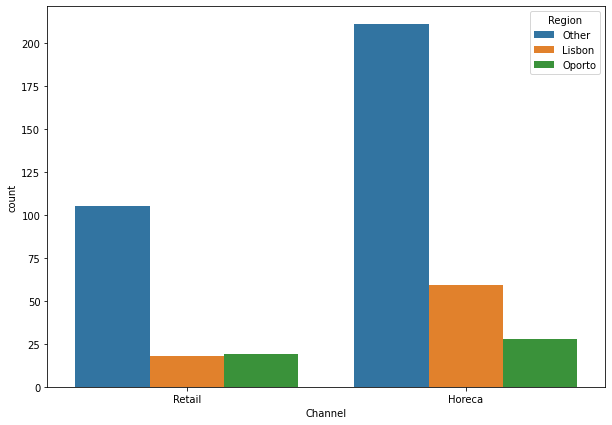

In [75]:
plt.figure(figsize=(10, 7))  
sns.countplot(x="Channel", hue="Region", data=df_cat)

From the histogram above, we can see that most of the data is from the Other regions for both retail and horeca. There is not a big difference in the amount of data when comparing Lisbon and Oporto in retail but there are more data information for Lisbon than Oporto in Horeca.

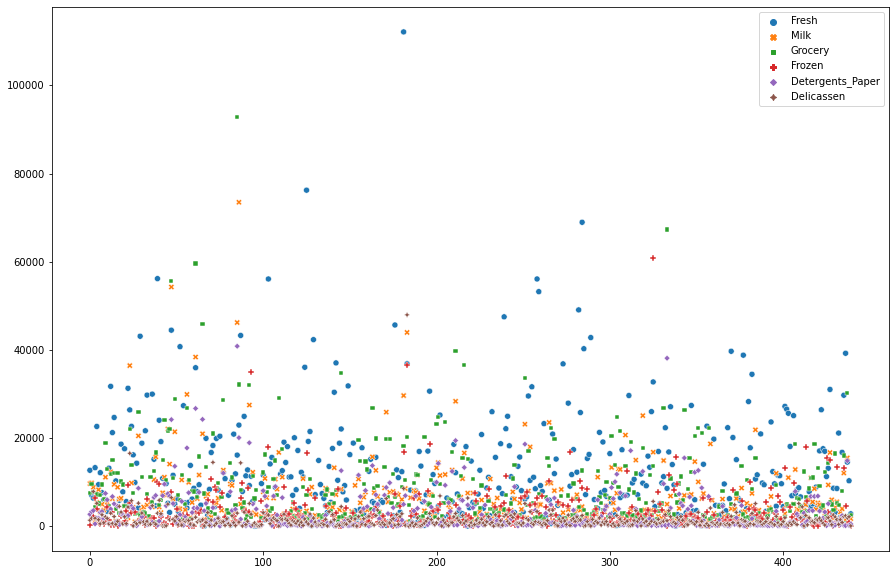

In [87]:
plt.figure(figsize=(15, 10))
sns.scatterplot(data=products)

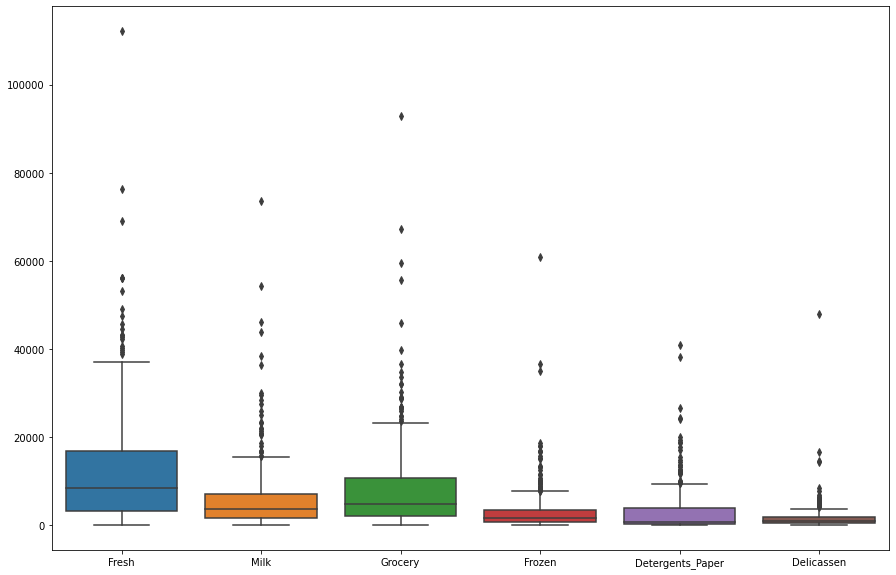

In [76]:
plt.figure(figsize=(15, 10))  
sns.boxplot(data=products)

The boxplot above shows that there is a greater range in spending values for the Fresh category, with it also containing the highest value spent in a year. It is followed then by Grocery and Milk. All the boxplots show the presence of a lot of outliers.

### Models

Below is an analysis and performance (silhouette score) of k-means clustering and Birch clustering. It's said that k-means clustering does not perform well in presence of categorical data as the Euclidean distance does not provide a meaningful output in such space. For that reason, the two categorical variables are not included in the cluster analysis.

Since the two removed categorical variables were the only ones that had a significant difference in magnitude compared to the other variables that were all measured in the same monetary units, scaling that data is not required.

#### K-means Clustering

K-means is a clustering algorithm based on a distance measurement (Euclidean distance) where a point is a assigned to a cluster based on its distance to a centroid.


In [77]:
#https://www.analyticsvidhya.com/blog/2019/08/comprehensive-guide-k-means-clustering/
# standardizing the data to compare the results between scaled and nonscaled data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_scaled = scaler.fit_transform(products)

# statistics of scaled data
pd.DataFrame(data_scaled).describe()

,0,1,2,3,4,5
count,4.400000e+02,4.400000e+02,4.400000e+02,4.400000e+02,4.400000e+02,4.400000e+02
mean,-2.422305e-17,-1.589638e-17,-6.030530e-17,1.135455e-17,-1.917658e-17,-8.276208e-17
std,1.001138e+00,1.001138e+00,1.001138e+00,1.001138e+00,1.001138e+00,1.001138e+00
min,-9.496831e-01,-7.787951e-01,-8.373344e-01,-6.283430e-01,-6.044165e-01,-5.402644e-01
25%,-7.023339e-01,-5.783063e-01,-6.108364e-01,-4.804306e-01,-5.511349e-01,-3.964005e-01
50%,-2.767602e-01,-2.942580e-01,-3.366684e-01,-3.188045e-01,-4.336004e-01,-1.985766e-01
75%,3.905226e-01,1.890921e-01,2.849105e-01,9.946441e-02,2.184822e-01,1.048598e-01
max,7.927738e+00,9.183650e+00,8.936528e+00,1.191900e+01,7.967672e+00,1.647845e+01


In [107]:
data_nonscaled = products.to_numpy()
print(type(data_scaled))
print(type(data_nonscaled))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [108]:
#https://www.analyticsvidhya.com/blog/2019/08/comprehensive-guide-k-means-clustering/
# defining the kmeans function with initialization as k-means++
kmeans = KMeans(n_clusters=5, init='k-means++')

# fitting the k means algorithm on scaled data
kmeans.fit(data_nonscaled)
kmeans.inertia_

53056177670.10686

Ideally the lower the inertia value the better but we can't just look at its value to decide the number of clusters as we can achieve a very low value of inertia by just increasing the number of clusters.

Text(0, 0.5, 'Inertia')

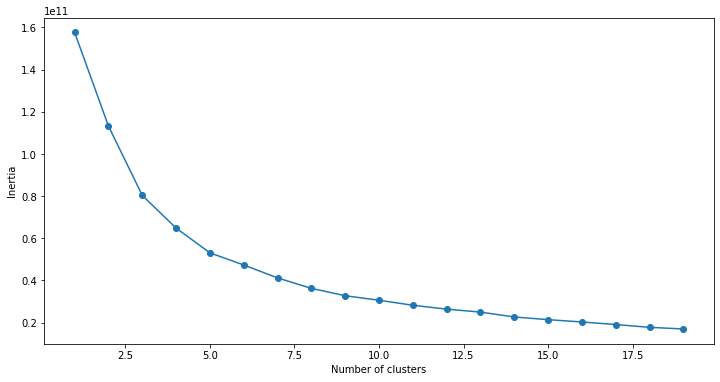

In [109]:
#https://www.analyticsvidhya.com/blog/2019/08/comprehensive-guide-k-means-clustering/
SSE = []
for cluster in range(1,20):
    kmeans = KMeans(n_jobs = -1, n_clusters = cluster, init='k-means++')
    kmeans.fit(data_nonscaled)
    SSE.append(kmeans.inertia_)

# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,20), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

The graph above is used to select an ideal number of cluster by finding the point in which there is a smaller drop in the inertia and the curve starts to flatten out (elbow method). It seems that creating 5 clusters would be a good choice.

In [110]:
#https://www.analyticsvidhya.com/blog/2019/08/comprehensive-guide-k-means-clustering/
# k means using 5 clusters and k-means++ initialization
kmeans = KMeans(n_jobs = -1, n_clusters = 5, init='k-means++')
kmeans.fit(data_nonscaled)
pred = kmeans.predict(data_nonscaled)

In [111]:
#https://www.analyticsvidhya.com/blog/2019/08/comprehensive-guide-k-means-clustering/
frame = pd.DataFrame(data = data_nonscaled,columns=products.columns)
frame['cluster'] = kmeans.labels_
frame.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,cluster
0,12669,9656,7561,214,2674,1338,0
1,7057,9810,9568,1762,3293,1776,0
2,6353,8808,7684,2405,3516,7844,0
3,13265,1196,4221,6404,507,1788,4
4,22615,5410,7198,3915,1777,5185,4


In [112]:
frame['cluster'].value_counts()

0    219
4    110
3     78
2     26
1      7
Name: cluster, dtype: int64

From the output above we can see that most of the data is allocated to cluster 1 (index 0) followed by cluster 3 (index 2) and cluster 5 (index 4). There is a cluster (cluster 2) with only one point.

In [113]:
frame_melt = frame.melt(id_vars="cluster")
frame_melt.head()

,cluster,variable,value
0,0,Fresh,12669
1,0,Fresh,7057
2,0,Fresh,6353
3,4,Fresh,13265
4,4,Fresh,22615


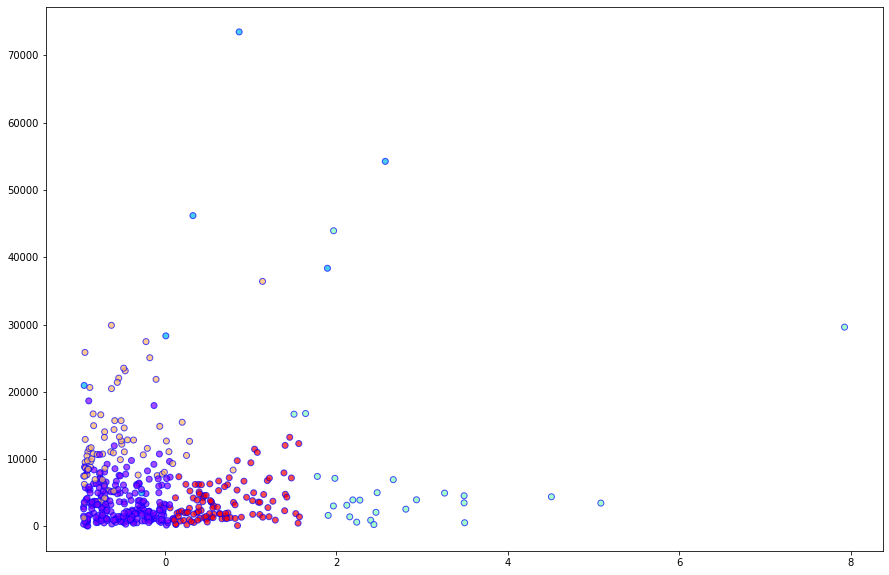

In [114]:
plt.figure(figsize=(15, 10))
plt.scatter(data_scaled[:,0], data_nonscaled[:,1], c=pred, cmap='rainbow', alpha=0.7, edgecolors='b')

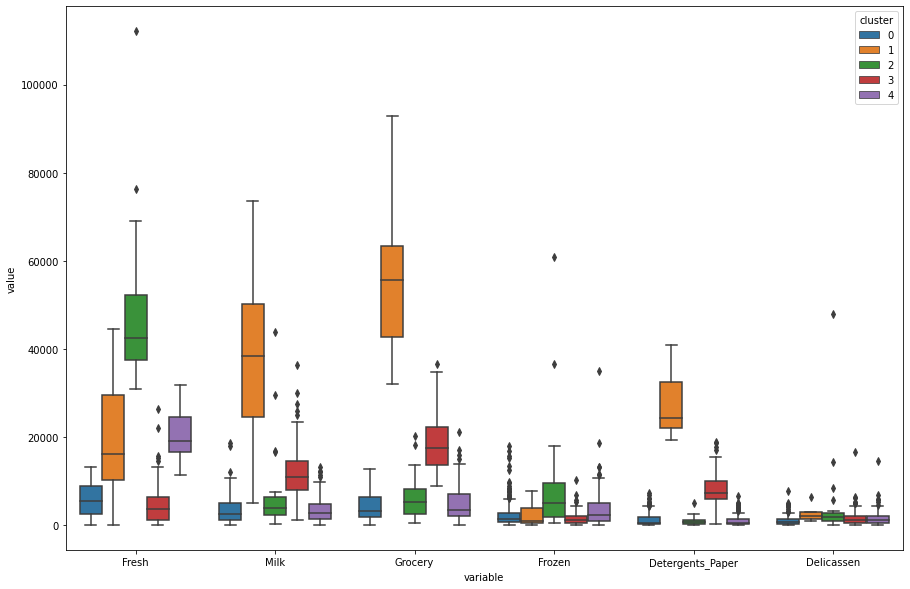

In [115]:
plt.figure(figsize=(15, 10))
bplot=sns.boxplot(x="variable", y="value", data=frame_melt, hue="cluster")

Here we have a boxplot of each product in each of the five clusters created. We can see that cluster 2 (index 1) has the highest values in spending for milk, grocery and detergents_paper. Cluster 3 (index 2) has the highest values for fresh and frozen. There is not a big difference in delicassen between all clusters. Cluster 2 (index 1) has the highest range in spending for fresh, milk, grocery and detergents_paper.

In [56]:
#variables = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']
#fig, ax = plt.subplots(2, 3, figsize=(15,10))
#for var, subplot in zip(variables, ax.flatten()):
#    sns.boxplot(x='cluster', y=var, data=frame, ax=subplot)    

In [116]:
from sklearn.metrics import silhouette_score
score = silhouette_score(data_nonscaled, pred, random_state=1)
score

0.3634715574068809

The silhouette reported, although positive, it's not that far from 0. It's not a good silhouette score and might indicate the presence of overlapping clusters.

#### Birch clustering

Balanced Iterative Reducing and Clustering using Hierarchies is a clustering method that can be used in large data sets as it generates smaller and more compact summary of the data set that contains as much as information as possible. It then uses that information to create clusters.

In [128]:
birc = Birch(n_clusters= 5)
birc.fit(data_nonscaled)
birc_pred = birc.predict(data_nonscaled)

Initially Birch was used with n_clusters = None, but that created 440 clusters. For the purpose of comparing the silhouette score to the one obtained by k-means, n_clusters was set to 5.

In [129]:
frame_birc = pd.DataFrame(data = data_nonscaled,columns=products.columns)
frame_birc['cluster'] = birc.labels_
frame_birc.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,cluster
0,12669,9656,7561,214,2674,1338,0
1,7057,9810,9568,1762,3293,1776,0
2,6353,8808,7684,2405,3516,7844,0
3,13265,1196,4221,6404,507,1788,0
4,22615,5410,7198,3915,1777,5185,3


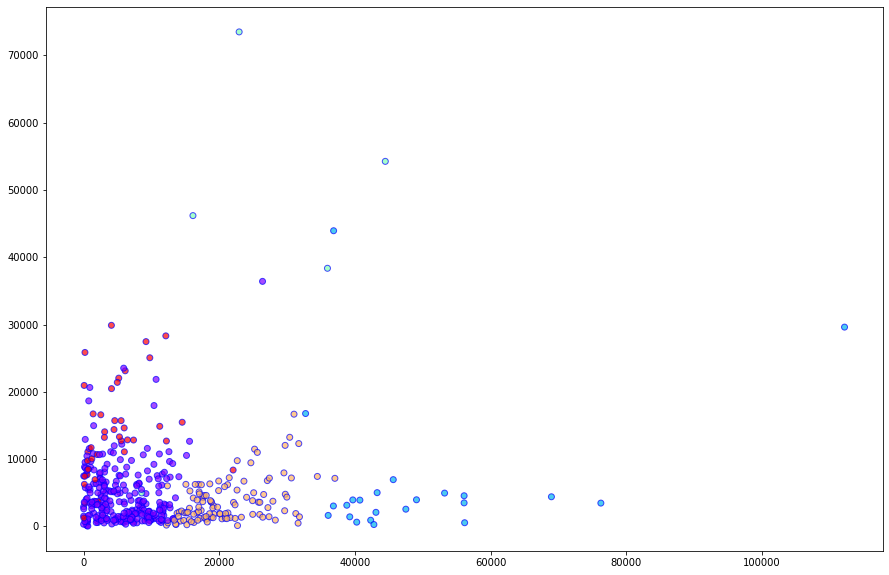

In [130]:
plt.figure(figsize=(15, 10))
plt.scatter(data_nonscaled[:,0], data_nonscaled[:,1], c=birc_pred, cmap='rainbow', alpha=0.7, edgecolors='b')

In [131]:
frame_birc['cluster'].value_counts()

0    261
3    111
4     40
1     23
2      5
Name: cluster, dtype: int64

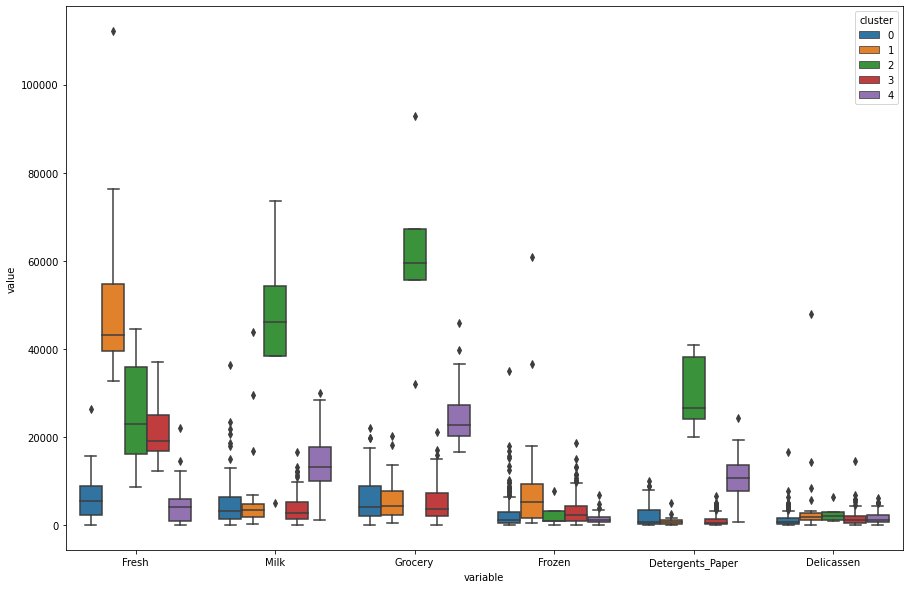

In [132]:
birch_melt = frame_birc.melt(id_vars="cluster")
plt.figure(figsize=(15, 10))
bplot=sns.boxplot(x="variable", y="value", data=birch_melt, hue="cluster")

In [133]:
birc_score = silhouette_score(data_scaled, birc_pred, random_state=1)
birc_score

0.20226538927093862

Birch clustering provided a lower (worse) silhouette score when compared to k-means.

### Conclusions

From results and plots observed in this lab we can see that there is a lot of overlapping within the clusters that were created using k-means and Birch clustering methods. The allocation of objects to cluster were different between the two methods with the biggest cluster in k-means containing 219 (almost 50% of the data) data points and the biggest cluster in Birch containing 261 data points (almost 60% of the data). The table below shows how many data points are allocated to each cluster in both methods.

| Cluster  | K-means  | Birch  | 
|---|---|---|
| 0  | 219  | 261  | 
| 1  | 7 | 23  | 
| 2  | 26  | 5  | 
| 3  | 78  | 111  |
| 4  | 110  | 40  |

Even though both methods were set to create 5 clusters, number that was selected based on the elbow method using inertia values for k-means (the Birch algorithm does not provide an inertia value), the silhouette score for the k-means method was better (higher).

Still, it is difficult to interpret what these clusters really represent for this particular data set as there are a lot of overlapping points.


### References
1. https://www.analyticsvidhya.com/blog/2019/08/comprehensive-guide-k-means-clustering/
2. https://seaborn.pydata.org/generated/seaborn.boxplot.html
3. https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
4. https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html#sklearn.metrics.silhouette_score
5. https://datascience.stackexchange.com/questions/22/k-means-clustering-for-mixed-numeric-and-categorical-data
6. https://scikit-learn.org/stable/modules/generated/sklearn.cluster.Birch.html
7. https://www.geeksforgeeks.org/ml-birch-clustering/